In [33]:
import pandas as pd
from importlib import reload
import dataset as d; reload(d)
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import ipywidgets as widgets
from ipywidgets import interact, FloatSlider

In [34]:
df = d.load_dataset()

In [35]:
PREDICTED_COLUMNS = ['diagnosis', 'radius_mean']
FEATURES = ['mean']
x, y = d.create_xy(df, FEATURES, PREDICTED_COLUMNS)
x = pd.DataFrame(StandardScaler().fit_transform(x), columns=x.columns)
N_FEATURES = x.shape[-1]

In [42]:
(x_train, y_train), (x_val, y_val), (x_test, y_test) = d.split_train_val_test(x, y, train_perc=0.6)

# Comparing Outlier detection methods

- Which features am I taking into account to detect outliers? 
    - Univariate 
        - Box plots, Z-Scores
    - Multivariate
- Can I assume a distribution(s) of values for my selected features? 
    - Parametric 
        - Z-Score, IQR score
    - Non-parametric
        - PCA, LMS, Proximity Based Models

### Sources of outliers
* Data entry errors
* Measurement errors (instrument errors)
* Experimental errors (data extraction or experiment planning/executing errors)
* Natural (not an error, novelties in data)

In [43]:
import itertools

def plot_confusion_matrix(cm, classes):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    

### IQR score

![title](http://www.statisticshowto.com/wp-content/uploads/2012/03/iqr.jpg)

In [44]:
def get_iqr_score(x):
    q1 = pd.DataFrame(x).quantile(0.25).values
    q3 = pd.DataFrame(x).quantile(0.75).values
    IQR = q3 - q1
    return IQR, q3, q1

IQR, q3, q1 = get_iqr_score(x_test)

In [45]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

k = FloatSlider(min=0, max=2.0, step=.05)
threshold_vote_outlier = FloatSlider(min=0, max=1, step=.01)

ui = widgets.HBox([k, threshold_vote_outlier])

def plot(x, outliers_idx, real_outlier_index):
    fig = plt.figure(figsize=(13, 8))
    ax = fig.add_subplot(111)
    ax.scatter(x[~outliers_idx, 0], x[~outliers_idx, 1], alpha=0.7, label='Inliers', c='r')
    ax.scatter(x[outliers_idx, 0], x[outliers_idx, 1], alpha=0.7, label='Predicted outliers', c='g')
    ax.scatter(x[real_outlier_index, 0], x[real_outlier_index, 1], alpha=0.2, label='Real outliers', c='b')

    plt.legend(loc='upper left')
    plt.grid()
    plt.show()
    
def iqr_get_outliers(x, spread, threshold):
    x_pca = pca.fit(x).transform(x)
    outliers_candidates = (x < (q1 - spread * IQR)) | (x > (q3 + spread * IQR))
    outliers_idx = np.apply_along_axis(lambda c: c.mean() >= threshold, 1, outliers_candidates) 
    return x_pca, outliers_idx

data, target = x_test, y_test
real_outliers_idx = (target[:, 0] == 'M')

def f(k, threshold_vote_outlier):    
    x_pca, outliers_idx = iqr_get_outliers(data, k, threshold_vote_outlier)
    plot_confusion_matrix(confusion_matrix(outliers_idx, real_outliers_idx), [False, True])
    plot(x_pca, outliers_idx, real_outliers_idx)
    

out = widgets.interactive_output(f, {'k': k, 'threshold_vote_outlier': threshold_vote_outlier})
display(ui, out)

HBox(children=(FloatSlider(value=0.0, max=2.0, step=0.05), FloatSlider(value=0.0, max=1.0, step=0.01)))

Output()

### Isolation Forest

* Separate each point from its neighbors
    - If it is a inlier, it will take longer to separate
    - If it is a outlier, it will separate rapidly
    
* Works well for multiple dimentions
* Works well for multiple dimentions

![title](images/outlier2.gif)

![title](images/inlier2.gif)

In [46]:
from sklearn.ensemble import IsolationForest

In [47]:
x_test_df = pd.DataFrame(x_test, columns=x.columns)

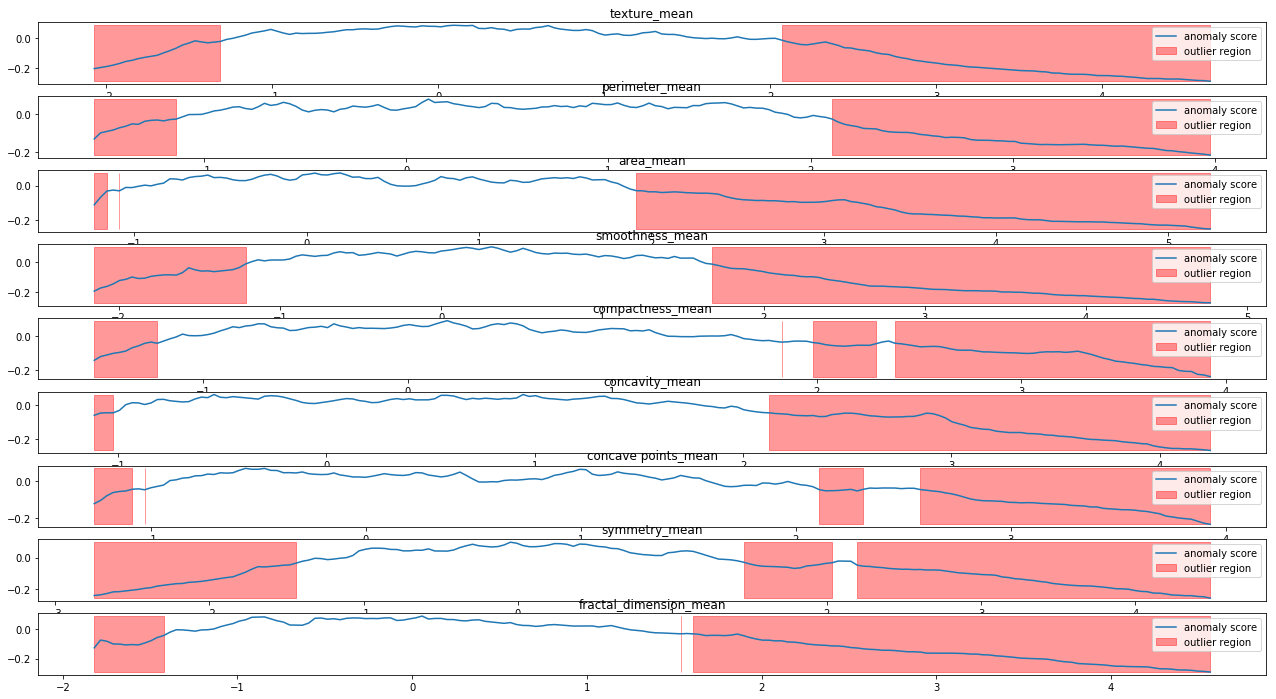

In [50]:
fig, axs = plt.subplots(N_FEATURES, figsize=(22, 12), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i, column in enumerate(x_test_df.columns):
    isolation_forest = IsolationForest()
    isolation_forest.fit(x_test_df[column].values.reshape(-1,1))

    xx = np.linspace(x_test_df[column].min(), x_test_df[column].max(), len(x_test_df)).reshape(-1,1)
    anomaly_score = isolation_forest.decision_function(xx)
    outlier = isolation_forest.predict(xx)
    
    axs[i].plot(xx, anomaly_score, label='anomaly score')
    axs[i].fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                     where=outlier==-1, color='r', 
                     alpha=.4, label='outlier region')
    axs[i].legend()
    axs[i].set_title(column)
fig
plt.show()

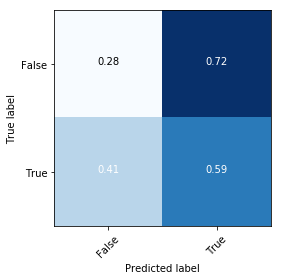

In [51]:
model =  IsolationForest()
model.fit(x_test)

outliers = pd.Series(model.predict(x_test)).map({1: True, -1: False})
plot_confusion_matrix(confusion_matrix(outliers, y_test[:, 0] == 'M'), [False, True])
plt.show()

## DBSCAN

In [52]:
from sklearn.cluster import DBSCAN

In [56]:
pca = PCA(n_components=2)

distance = FloatSlider(min=0.1, max=3.0, step=.05)
n_neighbors = FloatSlider(min=1, max=20, step=1)
ui = widgets.HBox([distance, n_neighbors])

def f(distance, n_neighbors):
    plt.figure(figsize=(10,10))
    x_test_transformed = pca.fit(x_test).transform(x_test)
    db = DBSCAN(eps=distance, min_samples=n_neighbors).fit(x_test_transformed)
    labels = db.labels_
    unique_labels = set(labels)
    
    for label in unique_labels:
        sample_mask = [True if l == label else False for l in labels]
        plt.plot(x_test_transformed[:, 0][sample_mask], x_test_transformed[:, 1][sample_mask], 'o');
    
    plt.grid()
    plt.show()
    
out = widgets.interactive_output(f, {'distance': distance, 'n_neighbors': n_neighbors})
display(ui, out)

HBox(children=(FloatSlider(value=0.1, max=3.0, min=0.1, step=0.05), FloatSlider(value=1.0, max=20.0, min=1.0, step=1.0)))

Output()

Done!